# **ASSIGNMENT 3**

**Task**: forecast the real price of gasoline for the US.

**Dataset**: gasoline.xlsx contains two monthly time series. The nominal price of gasoline and the CPI. 


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 40)
pd.set_option("display.precision", 2)

In [16]:
gasoline = pd.read_excel('gasoline.xls')

# rename the columns
gasoline.rename(columns=
                {'Unnamed: 1': 'CPI',
                 'Unnamed: 2': 'Nominal_Price',
                 'FRED Graph Observations': 'Time'},
                 inplace = True)

# convert to datetime
gasoline['Time'] = pd.to_datetime(gasoline['Time'], errors = 'coerce')

# remove the unnecessary descriptions
gasoline = gasoline.query("Time >= '1990-11-01'")

gasoline.head()

,Time,CPI,Nominal_Price
11,1990-11-01,1.32,133.7
12,1990-12-01,1.34,134.2
13,1991-01-01,1.18,134.7
14,1991-02-01,1.09,134.8
15,1991-03-01,1.04,134.8


# 1) create the real price of gasoline

CPI has value = 100 for 1984: is it meaningful, considering that the observations begin from 1990?

In [19]:
gasoline['Real_Price'] = (gasoline['Nominal_Price'] / gasoline['CPI'])
gasoline.head(5)

,Time,CPI,Nominal_Price,Real_Price
11,1990-11-01,1.32,133.7,100.98
12,1990-12-01,1.34,134.2,100.07
13,1991-01-01,1.18,134.7,114.15
14,1991-02-01,1.09,134.8,123.19
15,1991-03-01,1.04,134.8,129.62


## 2)  Plot real and nominal prices over time.

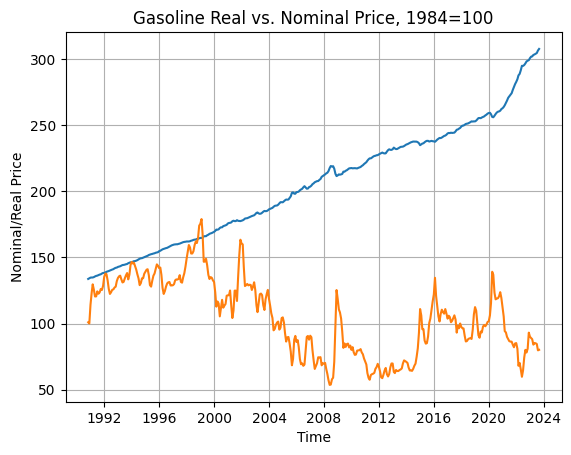

In [20]:
plt.plot(gasoline['Time'], gasoline['Nominal_Price'])
plt.plot(gasoline['Time'], gasoline['Real_Price'])

plt.title('Gasoline Real vs. Nominal Price, 1984=100')
plt.xlabel('Time')
plt.ylabel('Nominal/Real Price')
plt.grid()